# Importing libraries

In [1]:
from torch.utils.data import Dataset,DataLoader,random_split
from typing import Any,Tuple,Optional,Callable
import PIL
import csv
import pathlib
import torch
import torch.nn as nn
from torch.optim import Adam,lr_scheduler
from torchvision.transforms.v2 import ToTensor,Resize,Compose,ColorJitter,RandomRotation,AugMix,RandomCrop,GaussianBlur,RandomEqualize,RandomHorizontalFlip,RandomVerticalFlip
import matplotlib.pyplot as plt
import pickle

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

# selecting our gpu accelerator

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Make a custom class for the gtsrb dataset

We created GTSRB class is a custom dataset class for PyTorch, designed to handle the German Traffic Sign Recognition Benchmark (GTSRB) dataset. It inherits from PyTorch's Dataset class and is initialized with the dataset's root directory, the type of data split ('train' or 'test'), and an optional transform. The class reads the respective CSV file (Train.csv or Test.csv) and stores the image file paths and their corresponding class IDs. The __len__ method returns the total number of samples in the dataset. The __getitem__ method loads and returns a sample (an image and its class ID) at the specified index, applying any defined transformations to the image.

In [3]:
class GTSRB(Dataset):
    def __init__(self, root: str, split: str, transform: Optional[Callable] = None):
        self.base_folder = pathlib.Path(root)
        self.csv_file = self.base_folder / ('Train.csv' if split == 'train' else 'Test.csv')

        with open('/' + str(self.csv_file)) as csvfile:
            samples = [('/' + str(self.base_folder / row['Path']), int(row['ClassId']))
                       for row in csv.DictReader(csvfile, delimiter=',', skipinitialspace=True)]

        self.samples = samples
        self.split = split
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index: int) -> Tuple:
        path, classId = self.samples[index]
        sample = PIL.Image.open(path).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, classId


# Augmenting our data by applying some transformations (brightness, contrast, vertical-horizontal flip, Rotations, Blur...)

The `train_transforms` variable defines a series of image transformations for training data in PyTorch, using `Compose` to chain them together. It includes `ColorJitter` for altering brightness, contrast, saturation, and hue, `RandomEqualize` for random histogram equalization, `AugMix` for diverse augmentations, `RandomHorizontalFlip` and `RandomVerticalFlip` for random flips, `GaussianBlur` for blurring, and `RandomRotation` for rotating images. After these, images are resized to 50x50 pixels and converted to tensors. 

The `validation_transforms` variable, on the other hand, is simpler, with just resizing to 50x50 pixels and conversion to tensors, meant for validation data.

In [4]:
train_transforms = Compose([
    ColorJitter(brightness=1.0, contrast=0.5, saturation=1, hue=0.1),
    RandomEqualize(0.4),
    AugMix(),
    RandomHorizontalFlip(0.3),
    RandomVerticalFlip(0.3),
    GaussianBlur((3,3)),
    RandomRotation(30),

    Resize([50,50]),
    ToTensor(),
    
])
validation_transforms =  Compose([
    Resize([50,50]),
    ToTensor(),
    
])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


# splitting our dataset into train and validation 

In [5]:
def train_test_split(dataset,train_size):

    train_size = int(train_size * len(dataset))
    test_size = int(len(dataset) - train_size)
    return random_split(dataset,[train_size,test_size])

In [6]:
dataset = GTSRB(root='/content/drive/MyDrive/Traffic_Sign_Data', split="train")
train_set,validation_set = train_test_split(dataset,train_size=0.8)
print(f'training size : {len(train_set)}, Validation size : {len(validation_set)}')

training size : 31367, Validation size : 7842


# visualizing the data

The Python function `plot_augmented_images` uses the `matplotlib` library to visualize the effects of data augmentation on images from a given dataset. It takes a dataset and a transformation (`transform`) as inputs. The transformation includes random rotations of up to 30 degrees and random horizontal flipping. The function plots six images from the dataset in two rows: the first row shows the original images, and the second row shows the augmented versions. This is a useful tool for visually assessing the impact of specified image transformations.

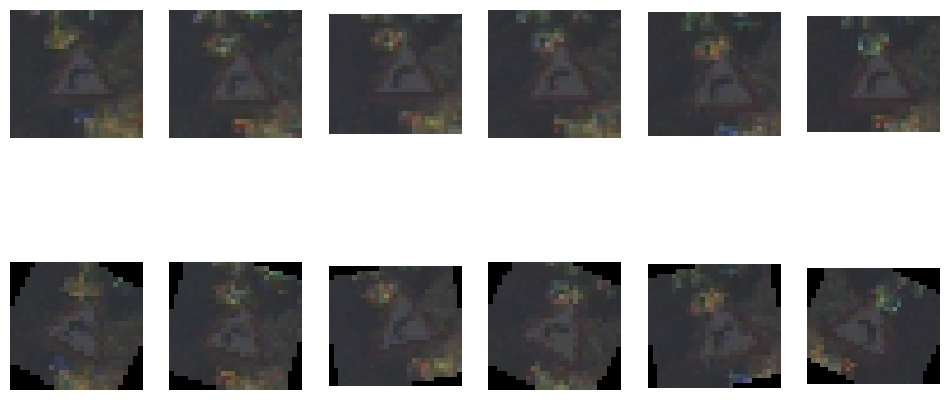

In [7]:
from torchvision import transforms

def plot_augmented_images(dataset, transform):
    plt.figure(figsize=(12, 6))
    for i in range(6):
        img, label = dataset[i]
        img_aug = transform(img)
        plt.subplot(2, 6, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.subplot(2, 6, i+7)
        plt.imshow(img_aug)
        plt.axis('off')
    plt.show()

transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip()
])

plot_augmented_images(dataset, transform)


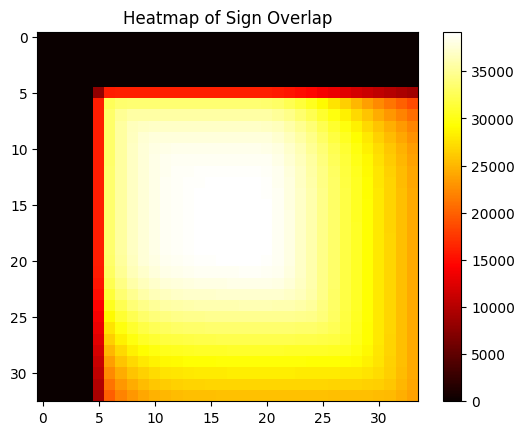

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read the CSV File
df = pd.read_csv('/content/drive/MyDrive/Traffic_Sign_Data/Train.csv') 

# Step 2: Extract Bounding Box Information
common_width = df['Width'].mode()[0]
common_height = df['Height'].mode()[0]

# Initialize an empty heatmap
heatmap = np.zeros((common_height, common_width))

# Populate the heatmap
for _, row in df.iterrows():
    x1, y1, x2, y2 = row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']
    # Adjust the bounding box coordinates if necessary (e.g., if you're resizing images)
    heatmap[y1:y2, x1:x2] += 1

# Step 3: Plot the Heatmap
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.title('Heatmap of Sign Overlap')
plt.colorbar()  # Optional: Add a color bar to indicate scale
plt.show()


The heatmap visualizes the regions where traffic signs are commonly located within the images of the dataset. The intensity of the colors corresponds to the frequency of sign appearances; hotter colors like red indicate higher frequencies. The brightest area in the center reflects the most common location for signs. This visualization aids in understanding the typical positions of traffic signs in the images and can inform the focus areas for detection algorithms.

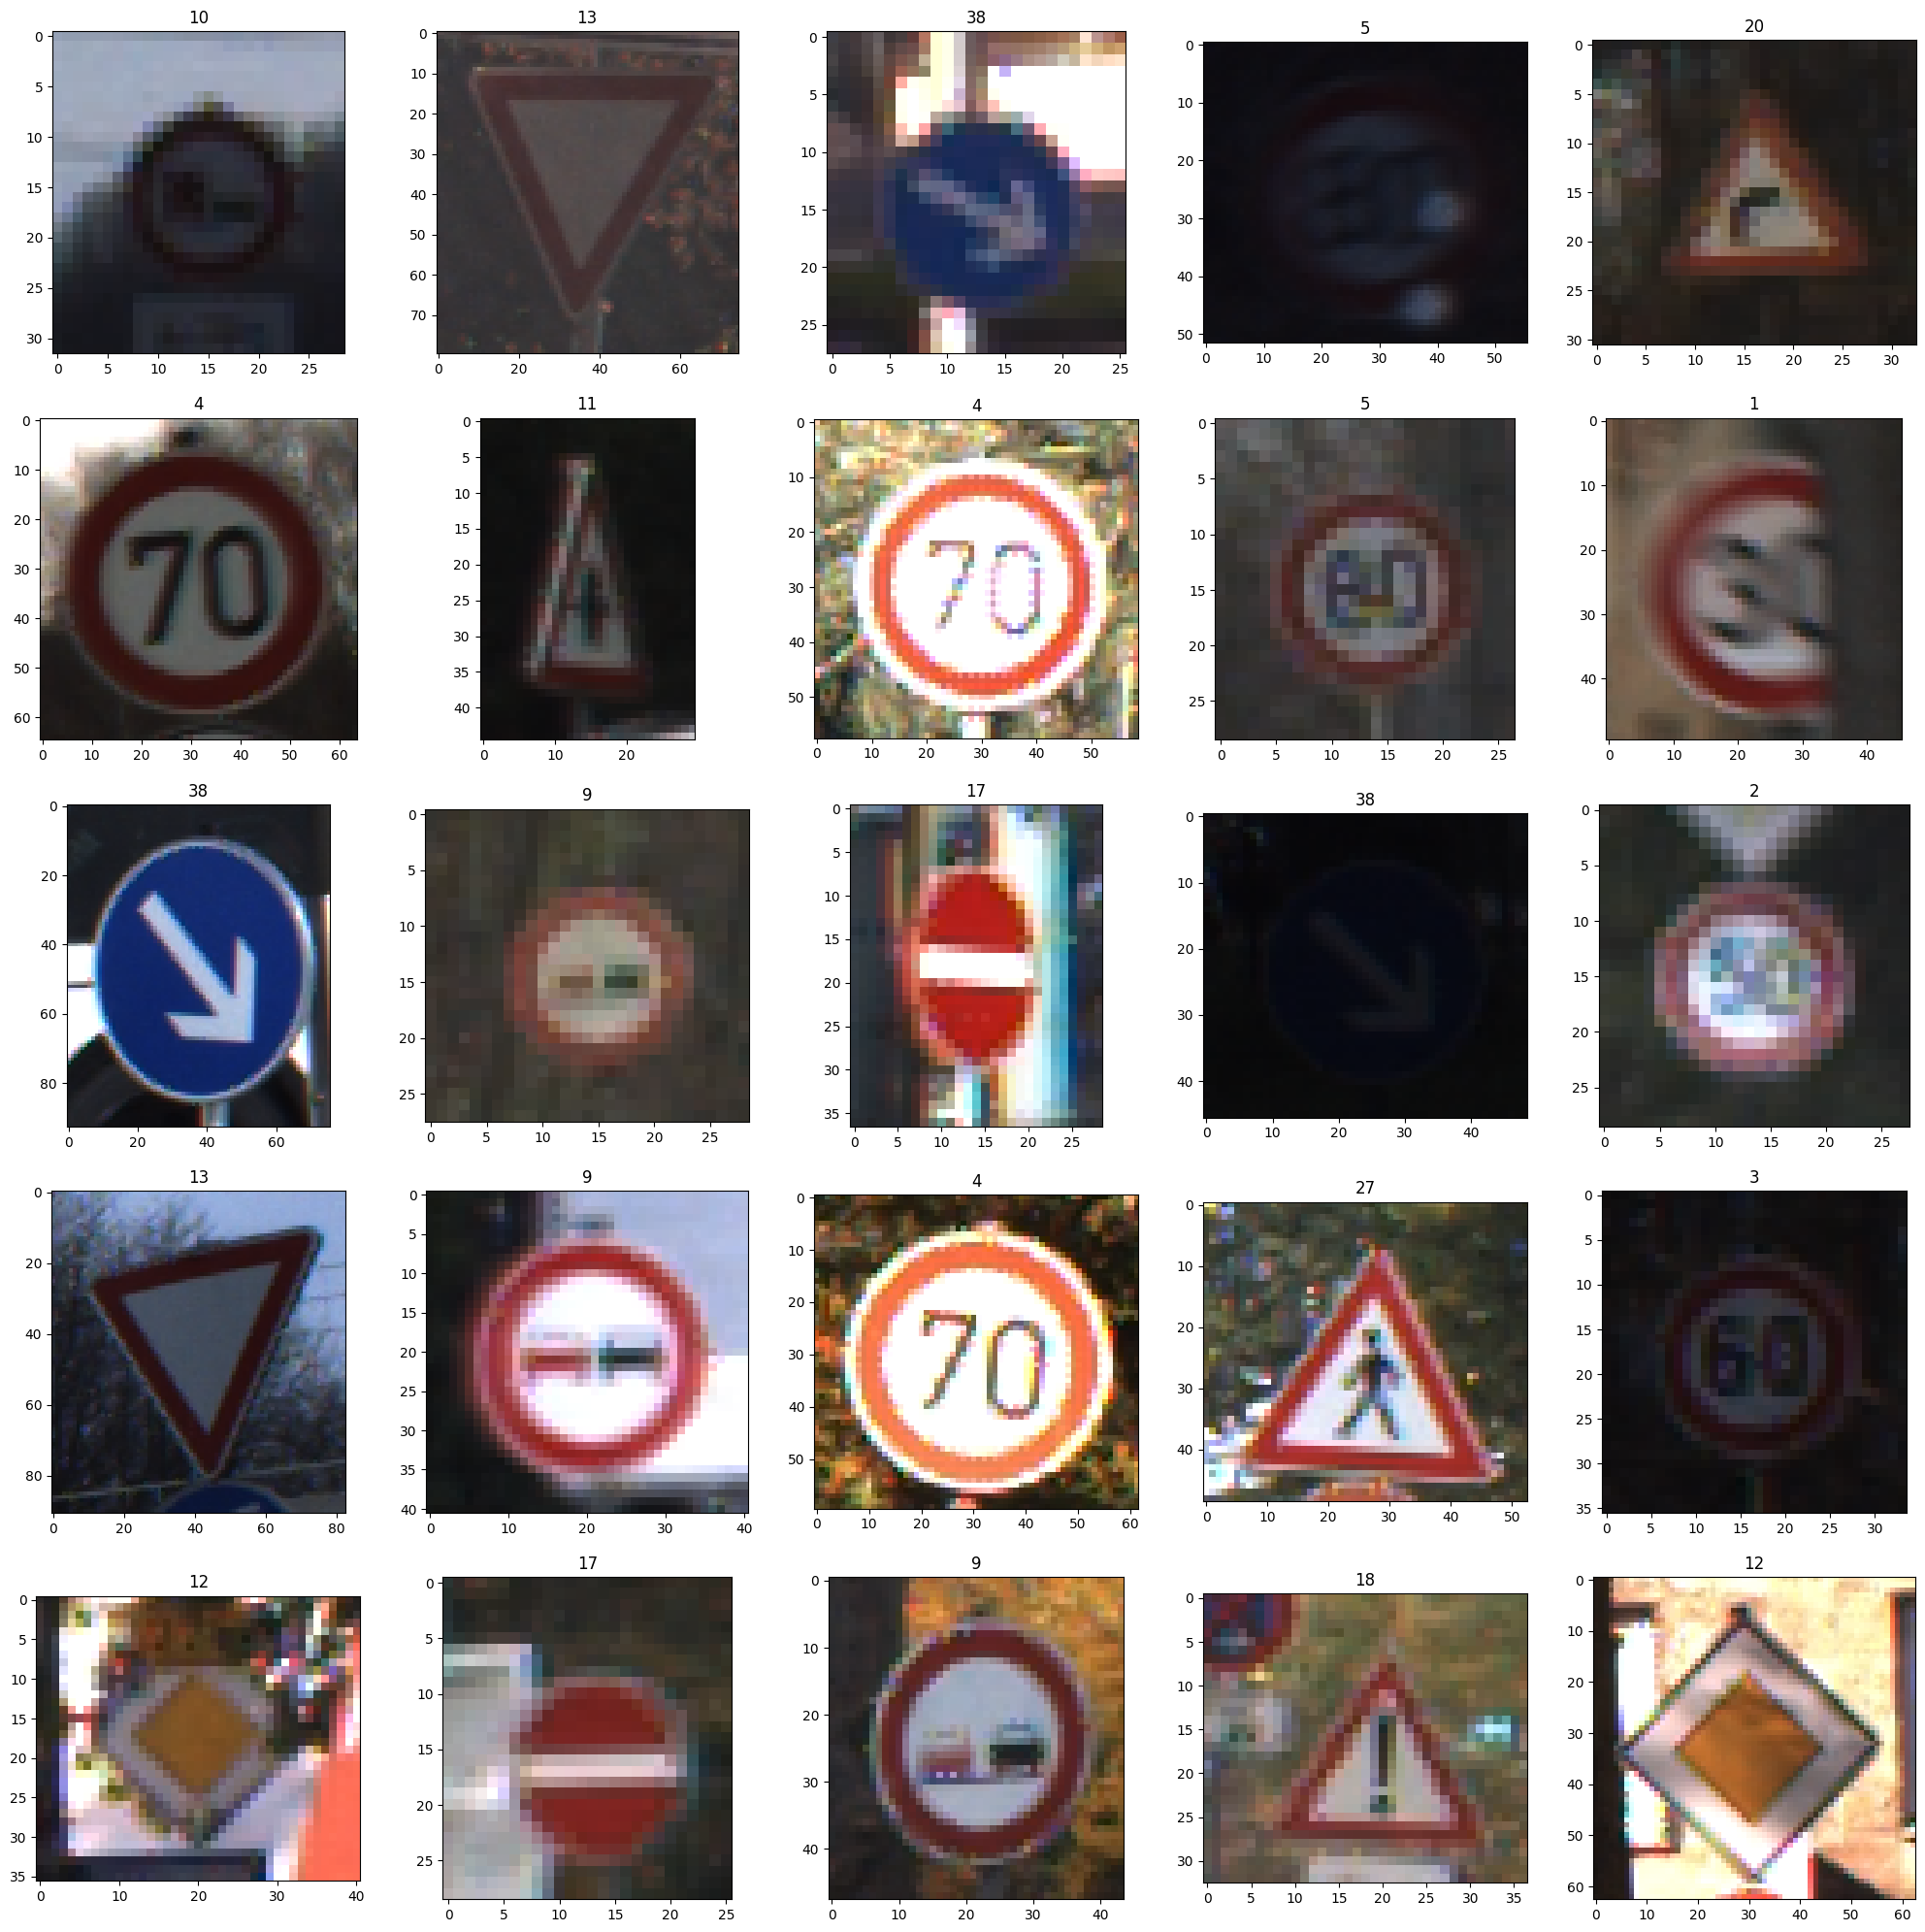

In [9]:
plt.figure(figsize=(25,25))
for i in range(1,26):
    input,label = train_set[i]
    plt.subplot(5,5,i)
    plt.title(label)
    plt.imshow(input)
    

# Applying the transformations

In [10]:
train_set.dataset.transform = train_transforms
validation_set.dataset.transform = validation_transforms

# Loading the data

In [11]:
BATCH_SIZE = 64
train_loader = DataLoader(dataset=train_set,batch_size=BATCH_SIZE,shuffle=True)
validation_loader = DataLoader(dataset=validation_set,batch_size=BATCH_SIZE)

# Building a convolutional neural network model

In [12]:
class GTSRB_MODEL(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(GTSRB_MODEL,self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
      
        self.metrics = {}
        
        self.flatten = nn.Flatten()
        
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.3)
       

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        

        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
        self.batchnorm2 = nn.BatchNorm2d(256)


        
        self.conv5 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3)
        self.conv6 = nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=3)
        self.batchnorm3 = nn.BatchNorm2d(1024)
        
       
       

        self.l1 = nn.Linear(1024*4*4,512)
        self.l2 = nn.Linear(512,128)
        self.batchnorm4 = nn.LayerNorm(128)
        self.l3 = nn.Linear(128,output_dim)
        
        
    def forward(self,input):
        
        conv = self.conv1(input)
        conv = self.conv2(conv)
        batchnorm = self.relu(self.batchnorm1(conv))
        maxpool = self.maxpool(batchnorm)

        conv = self.conv3(maxpool)
        conv = self.conv4(conv)
        batchnorm = self.relu(self.batchnorm2(conv))
        maxpool = self.maxpool(batchnorm)

        conv = self.conv5(maxpool)
        conv = self.conv6(conv)
        batchnorm = self.relu(self.batchnorm3(conv))
        maxpool = self.maxpool(batchnorm)
        
        
        
        
       
        
        flatten = self.flatten(maxpool)
        
        dense_l1 = self.l1(flatten)
        dropout = self.dropout3(dense_l1)
        dense_l2 = self.l2(dropout)
        batchnorm = self.batchnorm4(dense_l2)
        dropout = self.dropout2(batchnorm)
        output = self.l3(dropout)
        
       
        return output
    
    def training_metrics(self,positives,data_size,loss):
        acc = positives/data_size
        return loss,acc
    
    def validation_metrics(self,validation_data,loss_function):
       data_size = len(validation_data)
       correct_predictions = 0
       total_samples = 0
       val_loss = 0

       model = self.eval()
       with torch.no_grad() : 
        for step,(input,label) in enumerate(validation_data):
            input,label = input.to(device),label.to(device)
            prediction = model.forward(input)
            loss = loss_function(prediction,label)
            val_loss = loss.item()
            _,predicted = torch.max(prediction,1)
            correct_predictions += (predicted == label).sum().item()
            total_samples += label.size(0)

       val_acc = correct_predictions/total_samples

       return val_loss,val_acc

    def history(self):
        return self.metrics

            


    def compile(self,train_data,validation_data,epochs,loss_function,optimizer,learning_rate_scheduler):
        val_acc_list = []
        val_loss_list = []

        train_acc_list = []
        train_loss_list = []

        learning_rate_list = []

        print('training started ...')
        STEPS = len(train_data)
        for epoch in range(epochs):
            lr = optimizer.param_groups[0]["lr"]
            learning_rate_list.append(lr)
            correct_predictions = 0
            total_examples = 0
            loss = 0
            with tqdm.trange(STEPS) as progress:

                for step,(input,label) in enumerate(train_loader):

                    input,label = input.to(device),label.to(device)
                    prediction = self.forward(input)

                    _, predicted = torch.max(prediction, 1)
                    correct_predictions += (predicted == label).sum().item()
                    total_examples += label.size(0)
                    l = loss_function(prediction,label)
                    loss = l.item()
                    l.backward()
                    optimizer.step()
                    optimizer.zero_grad()

                    progress.colour = 'green'
                    progress.desc = f'Epoch [{epoch}/{EPOCHS}], Step [{step}/{STEPS}], Learning Rate [{lr}], Loss [{"{:.4f}".format(l)}], Accuracy [{"{:.4f}".format(correct_predictions/total_examples)}]'
                    progress.update(1)

            training_loss,training_acc = self.training_metrics(correct_predictions,total_examples,loss)
            train_acc_list.append(training_acc)
            train_loss_list.append(training_loss)

            val_loss, val_acc = self.validation_metrics(validation_data,loss_function)
            val_acc_list.append(val_acc)
            val_loss_list.append(val_loss)
            
            print(f'val_accuracy [{val_acc}], val_loss [{val_loss}]')

            
            learning_rate_scheduler.step()
        
        metrics_dict = {
                'train_acc':train_acc_list,
                'train_loss':train_loss_list,
                'val_acc':val_acc_list,
                'val_loss':val_loss_list,
                'learning_rate':optimizer.param_groups[0]["lr"]
            }
        self.metrics = metrics_dict
        print('training complete !')  

The `GTSRB_MODEL` is a custom deep learning model designed for traffic sign recognition, inheriting from PyTorch's `nn.Module`. It's composed of convolutional layers (`Conv2d`), batch normalization layers (`BatchNorm2d`), dropout layers to prevent overfitting (`Dropout`), and fully connected layers (`Linear`). The model applies the ReLU activation function and max pooling for non-linear transformations and dimensionality reduction. It includes a `forward` method defining the data flow during inference, functions to compute training and validation metrics, and a `compile` method for the training process, managing the training steps, loss calculation, and learning rate scheduling. The model's architecture is structured to learn from complex patterns in traffic sign images, aiming to achieve high accuracy in classification tasks.

# Training our model

In [13]:
import tqdm
EPOCHS = 20
LEARNING_RATE = 0.0008
INPUT_DIM = 3*50*50
OUTPUT_DIM = 43
model = GTSRB_MODEL(INPUT_DIM,OUTPUT_DIM).to(device)

optimizer = Adam(params=model.parameters(),lr=LEARNING_RATE)
lr_s = lr_scheduler.LinearLR(optimizer,start_factor=1.0,end_factor=0.5,total_iters=10)
loss = nn.CrossEntropyLoss()

In [14]:
model.compile(train_data=train_loader,validation_data=validation_loader,epochs=EPOCHS,loss_function=loss,optimizer=optimizer,learning_rate_scheduler=lr_s)

training started ...


Epoch [0/20], Step [490/491], Learning Rate [0.0008], Loss [0.0467], Accuracy [0.6456]: 100%|██████████| 491/491 [04:35<00:00,  1.78it/s]


val_accuracy [0.9809997449630197], val_loss [0.10044644773006439]


Epoch [1/20], Step [490/491], Learning Rate [0.00076], Loss [0.3174], Accuracy [0.9893]: 100%|██████████| 491/491 [00:51<00:00,  9.49it/s]


val_accuracy [0.9776842642183117], val_loss [0.03614717721939087]


Epoch [2/20], Step [490/491], Learning Rate [0.00072], Loss [0.1117], Accuracy [0.9953]: 100%|██████████| 491/491 [00:53<00:00,  9.20it/s]


val_accuracy [0.9952818158633002], val_loss [0.006975500378757715]


Epoch [3/20], Step [490/491], Learning Rate [0.00068], Loss [0.0042], Accuracy [0.9980]: 100%|██████████| 491/491 [00:52<00:00,  9.33it/s]


val_accuracy [0.9934965570007651], val_loss [0.005163972731679678]


Epoch [4/20], Step [490/491], Learning Rate [0.00064], Loss [0.0013], Accuracy [0.9995]: 100%|██████████| 491/491 [00:52<00:00,  9.43it/s]


val_accuracy [0.9977046671767407], val_loss [0.0027559008449316025]


Epoch [5/20], Step [490/491], Learning Rate [0.0006000000000000001], Loss [0.0031], Accuracy [0.9980]: 100%|██████████| 491/491 [00:54<00:00,  9.04it/s]


val_accuracy [0.9877582249426167], val_loss [0.02222149260342121]


Epoch [6/20], Step [490/491], Learning Rate [0.0005600000000000001], Loss [0.0014], Accuracy [0.9984]: 100%|██████████| 491/491 [00:54<00:00,  8.97it/s]


val_accuracy [0.9970670747258352], val_loss [0.0019587522838264704]


Epoch [7/20], Step [490/491], Learning Rate [0.0005200000000000001], Loss [0.0002], Accuracy [0.9999]: 100%|██████████| 491/491 [00:54<00:00,  9.09it/s]


val_accuracy [0.9987248150981892], val_loss [0.0010849436512216926]


Epoch [8/20], Step [490/491], Learning Rate [0.00048000000000000007], Loss [0.0003], Accuracy [1.0000]: 100%|██████████| 491/491 [00:50<00:00,  9.66it/s]


val_accuracy [0.9987248150981892], val_loss [0.0006259680376388133]


Epoch [9/20], Step [490/491], Learning Rate [0.00044000000000000007], Loss [0.0001], Accuracy [1.0000]: 100%|██████████| 491/491 [00:52<00:00,  9.28it/s]


val_accuracy [0.9988523335883703], val_loss [0.0004469029954634607]


Epoch [10/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0000], Accuracy [1.0000]: 100%|██████████| 491/491 [00:51<00:00,  9.45it/s]


val_accuracy [0.9987248150981892], val_loss [0.0003178069891873747]


Epoch [11/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0001], Accuracy [1.0000]: 100%|██████████| 491/491 [00:51<00:00,  9.58it/s]


val_accuracy [0.9987248150981892], val_loss [0.00023129995679482818]


Epoch [12/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0001], Accuracy [1.0000]: 100%|██████████| 491/491 [00:51<00:00,  9.45it/s]


val_accuracy [0.9987248150981892], val_loss [0.0001671136124059558]


Epoch [13/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0001], Accuracy [1.0000]: 100%|██████████| 491/491 [00:50<00:00,  9.66it/s]


val_accuracy [0.9987248150981892], val_loss [0.00014173213276080787]


Epoch [14/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0000], Accuracy [1.0000]: 100%|██████████| 491/491 [00:52<00:00,  9.38it/s]


val_accuracy [0.9987248150981892], val_loss [9.750571916811168e-05]


Epoch [15/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0000], Accuracy [1.0000]: 100%|██████████| 491/491 [00:51<00:00,  9.61it/s]


val_accuracy [0.9987248150981892], val_loss [7.683819421799853e-05]


Epoch [16/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0000], Accuracy [1.0000]: 100%|██████████| 491/491 [00:51<00:00,  9.56it/s]


val_accuracy [0.9987248150981892], val_loss [5.9854286519112065e-05]


Epoch [17/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0000], Accuracy [1.0000]: 100%|██████████| 491/491 [00:50<00:00,  9.77it/s]


val_accuracy [0.9988523335883703], val_loss [4.25394500780385e-05]


Epoch [18/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0000], Accuracy [1.0000]: 100%|██████████| 491/491 [00:50<00:00,  9.73it/s]


val_accuracy [0.9988523335883703], val_loss [3.467645728960633e-05]


Epoch [19/20], Step [490/491], Learning Rate [0.0004000000000000001], Loss [0.0000], Accuracy [1.0000]: 100%|██████████| 491/491 [00:52<00:00,  9.44it/s]


val_accuracy [0.9987248150981892], val_loss [2.6666224584914744e-05]
training complete !


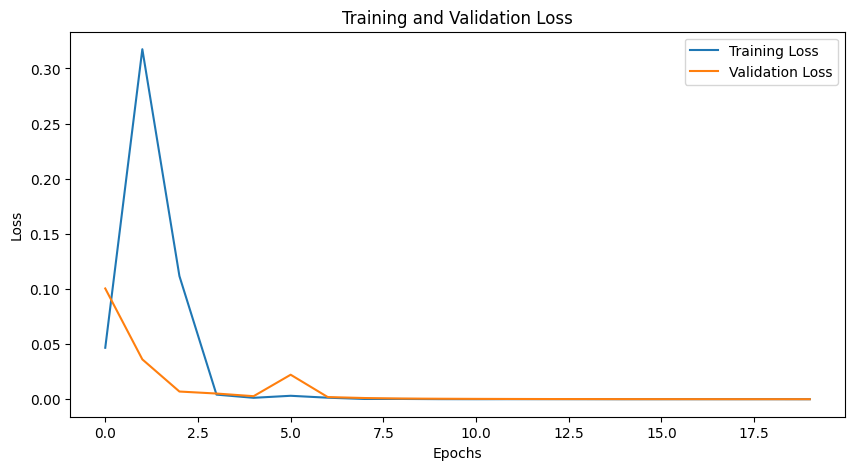

In [15]:
import matplotlib.pyplot as plt
# Assuming the model has been trained and the history is stored in model.metrics
train_loss_list = model.metrics['train_loss']
val_loss_list = model.metrics['val_loss']

# Assuming 'train_loss_list' and 'val_loss_list' contain the training and validation losses for each epoch
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


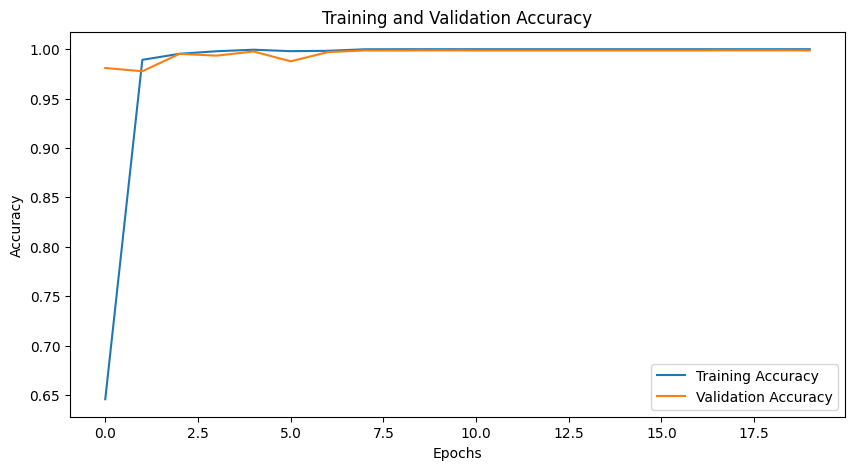

In [16]:
import matplotlib.pyplot as plt

# Ensure these lists are defined and populated with the accuracy values from your training process
train_acc_list = model.metrics['train_acc']
val_acc_list = model.metrics['val_acc']

plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [17]:
transforms = Compose([
    Resize([50,50]),
    ToTensor(),
    
])

testdata = GTSRB(root='/content/drive/MyDrive/Traffic_Sign_Data',split='test',transform=transforms)
print('testing size :',len(testdata))
test_dataloader = DataLoader(testdata)

testing size : 12630


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [18]:
from sklearn.metrics import accuracy_score

y_pred = []
y_true = []
model = model.eval().to(device)
with tqdm.tqdm(colour='red',total=len(test_dataloader)) as progress:
  
  with torch.no_grad() : 
    for id,(input,label) in enumerate(iter(test_dataloader)):
        input,label = input.to(device),label.to(device)
        y_true.append(label.item())
        prediction = model.forward(input)
        _,prediction = torch.max(prediction,1)
        y_pred.append(prediction.item())
        
        progress.desc = f'Test Accuracy : {accuracy_score(y_true,y_pred)} '
        progress.update(1)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Test Accuracy : 0.9908946951702297 : 100%|██████████| 12630/12630 [03:37<00:00, 57.97it/s]
